# XgBoost aproach

### Import preprocess data set

In [78]:
from preprocessing import preprocessing_data

# Import data set
train_df_X, train_df_Y, test_df_X, test_df_Y, validate_df_X, validate_df_Y  = preprocessing_data("data/regularite-mensuelle-tgv-aqst.csv")

### Preparation of data


In [39]:
print("Train X size:", train_df_Y.shape)
print("Train Y size:", train_df_X.shape)
print("Test X size:", test_df_Y.shape)
print("Test Y size:", test_df_X.shape)
print("Validation X size:", validate_df_X.shape)
print("Validation Y size:", validate_df_Y.shape)

Train X size: (5942, 7)
Train Y size: (5942, 125)
Test X size: (1486, 7)
Test Y size: (1486, 125)
Validation X size: (726, 125)
Validation Y size: (726, 7)


We create 2 models to predict the percentage (prct) of delay and de total delay mean

In [79]:
# Percentage datafame
train_df_Y_prct     = train_df_Y.iloc[:,:-1]
test_df_Y_prct      = test_df_Y.iloc[:,:-1]
validate_df_Y_prct  = validate_df_Y.iloc[:,:-1]

# Delay total mean datafame
train_df_Y_retard     = train_df_Y.iloc[:,-1]
test_df_Y_retard      = test_df_Y.iloc[:,-1]
validate_df_Y_retard  = validate_df_Y.iloc[:,-1]

#### Try outliers taking out

In [74]:
### Pequena prueba
import xgboost as xgb

Q1 = train_df_Y['total_retard_mean'].quantile(0.25)
Q3 = train_df_Y['total_retard_mean'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (train_df_Y['total_retard_mean'] >= Q1 - 1.5 * IQR) & (train_df_Y['total_retard_mean'] <= Q3 + 1.5 *IQR)
retards_df_outliers_Y = train_df_Y.loc[filter].iloc[:,-1]
retards_df_outliers_X = train_df_X.loc[filter]
dtrain_reg_retard_outliers = xgb.DMatrix(retards_df_outliers_X, retards_df_outliers_Y, enable_categorical=False)

In [75]:
# Test and Training 
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
evals = [(dtrain_reg_retard_outliers, "train"), (dtest_reg_retard, "test")]

model_retard2 = xgb.train(
   params=params,
   dtrain=dtrain_reg_retard_outliers,
   num_boost_round=n,
   evals=evals,
   verbose_eval=5, # Every ten rounds
   # Activate early stopping
   early_stopping_rounds=20
)

[0]	train-rmse:0.79003	test-rmse:1.02156
[5]	train-rmse:0.51946	test-rmse:0.87559
[10]	train-rmse:0.47663	test-rmse:0.86862
[15]	train-rmse:0.46000	test-rmse:0.86686
[20]	train-rmse:0.44563	test-rmse:0.86495
[25]	train-rmse:0.43493	test-rmse:0.86491
[30]	train-rmse:0.42665	test-rmse:0.86631
[35]	train-rmse:0.41555	test-rmse:0.86633
[40]	train-rmse:0.40473	test-rmse:0.86063
[45]	train-rmse:0.39529	test-rmse:0.85791
[50]	train-rmse:0.38769	test-rmse:0.85926
[55]	train-rmse:0.38129	test-rmse:0.86014
[60]	train-rmse:0.37335	test-rmse:0.85929
[65]	train-rmse:0.36710	test-rmse:0.85568
[70]	train-rmse:0.35770	test-rmse:0.85652
[75]	train-rmse:0.34869	test-rmse:0.85719
[80]	train-rmse:0.34229	test-rmse:0.85716
[84]	train-rmse:0.33694	test-rmse:0.85667


In [81]:
# validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard = model_retard2.predict(dtest_reg_retard)

# Root Mean Squared Error
rmse_retard = mean_squared_error(pred_retard, test_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard:.3f}")

r2_retatd = r2_score(pred_retard, test_df_Y_retard)
print(f"R2 of the base reatard model: {r2_retatd:.3f}")

RMSE of the base reatard model: 0.857
R2 of the base reatard model: -1.310


### Prediction of total delay mean

In [20]:
import xgboost as xgb

# Create regression matrices
dtrain_reg_retard = xgb.DMatrix(train_df_X, train_df_Y_retard, enable_categorical=False)
dtest_reg_retard = xgb.DMatrix(test_df_X, test_df_Y_retard, enable_categorical=False)
dval_reg_retard = xgb.DMatrix(validate_df_X, validate_df_Y_retard, enable_categorical=False)


#### Train
```num_boost_round``` Number of boosting rounds, Internally, XGBoost minimizes the loss function RMSE in small incremental rounds (more on this later)

```tree_method``` To gpu_hist, which enables GPU acceleration

In [44]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
model_retard = xgb.train(
   params=params,
   dtrain=dtrain_reg_retard,
   num_boost_round=n,
)

#### Test

In [45]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard = model_retard.predict(dtest_reg_retard)

# Root Mean Squared Error
rmse_retard = mean_squared_error(pred_retard, test_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard:.3f}")

r2_retatd = r2_score(test_df_Y_retard, pred_retard)
print(f"R2 of the base reatard model: {r2_retatd:.3f}")

RMSE of the base reatard model: 1.213
R2 of the base reatard model: -0.434


In [46]:
# validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard = model_retard.predict(dval_reg_retard)

# Root Mean Squared Error
rmse_retard = mean_squared_error(pred_retard, validate_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard:.3f}")

r2_retatd = r2_score(validate_df_Y_retard, pred_retard)
print(f"R2 of the base reatard model: {r2_retatd:.3f}")

RMSE of the base reatard model: 1.093
R2 of the base reatard model: 0.046


In [49]:
error = pred_retard -validate_df_Y_retard
sum(error)/len(error)

-0.22162527668269832

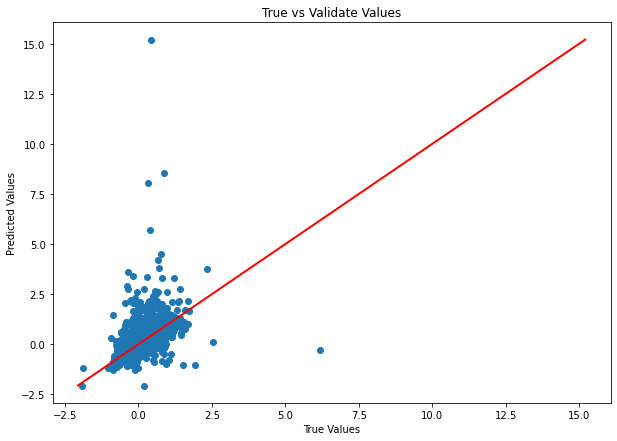

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(pred_retard, validate_df_Y_retard)
plt.plot([validate_df_Y_retard.min(), validate_df_Y_retard.max()], [validate_df_Y_retard.min(), validate_df_Y_retard.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Validate Values')
plt.show()

#### Using Test Sets During Training

We will use evaluation arrays that allow us to see model performance as it gets improved incrementally across boosting rounds.

In [47]:
# Test and Training 
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
evals = [(dtrain_reg_retard, "train"), (dtest_reg_retard, "test")]

model_retard2 = xgb.train(
   params=params,
   dtrain=dtrain_reg_retard,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10 # Every ten rounds
)

[0]	train-rmse:0.97453	test-rmse:0.96276
[10]	train-rmse:0.67632	test-rmse:0.76609
[20]	train-rmse:0.62046	test-rmse:0.76538
[30]	train-rmse:0.58705	test-rmse:0.76744
[40]	train-rmse:0.53588	test-rmse:0.77361
[50]	train-rmse:0.51258	test-rmse:0.77956
[60]	train-rmse:0.48211	test-rmse:0.78185
[70]	train-rmse:0.45510	test-rmse:0.78068
[80]	train-rmse:0.43425	test-rmse:0.78260
[90]	train-rmse:0.41330	test-rmse:0.78482
[99]	train-rmse:0.39939	test-rmse:0.78771


Early stopping forces XGBoost to watch the validation loss, and if it stops improving for a specified number of rounds, it automatically stops training.

In [53]:
# Test and Training 
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
evals = [(dtrain_reg_retard, "train"), (dtest_reg_retard, "test")]

model_retard2 = xgb.train(
   params=params,
   dtrain=dtrain_reg_retard,
   num_boost_round=n,
   evals=evals,
   verbose_eval=5, # Every ten rounds
   # Activate early stopping
   early_stopping_rounds=20
)

[0]	train-rmse:0.97453	test-rmse:0.96276


[5]	train-rmse:0.74544	test-rmse:0.79195
[10]	train-rmse:0.67632	test-rmse:0.76609
[15]	train-rmse:0.64488	test-rmse:0.76571
[20]	train-rmse:0.62046	test-rmse:0.76538
[25]	train-rmse:0.59879	test-rmse:0.76660
[30]	train-rmse:0.58705	test-rmse:0.76744
[31]	train-rmse:0.58134	test-rmse:0.76770


In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard2 = model_retard2.predict(dtest_reg_retard)

# Root Mean Squared Error
rmse_retard2 = mean_squared_error(pred_retard2, test_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard2:.3f}")

r2_retatd2 = r2_score(test_df_Y_retard, pred_retard2)
print(f"R2 of the base reatard model: {r2_retatd2:.3f}")

RMSE of the base reatard model: 1.173
R2 of the base reatard model: -0.341


In [54]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard2 = model_retard2.predict(dval_reg_retard)

# Root Mean Squared Error
rmse_retard2 = mean_squared_error(pred_retard2, validate_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard2:.3f}")

r2_retatd2 = r2_score( validate_df_Y_retard, pred_retard2)
print(f"R2 of the base reatard model: {r2_retatd2:.3f}")

RMSE of the base reatard model: 1.057
R2 of the base reatard model: 0.109


#### Add Cross-Validation

In [37]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 1000
results_retard = xgb.cv(
   params, dtrain_reg_retard,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20
)

In [42]:
display(results_retard.head())
print("CV best score", results_retard['test-rmse-mean'].min())

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.960314,0.016591,0.971755,0.095082
1,0.867578,0.016854,0.890658,0.097126
2,0.809208,0.016901,0.845839,0.097485
3,0.770836,0.015004,0.819961,0.097484
4,0.742078,0.014459,0.805543,0.097482


CV best score 0.783035626238808


#### Plot results

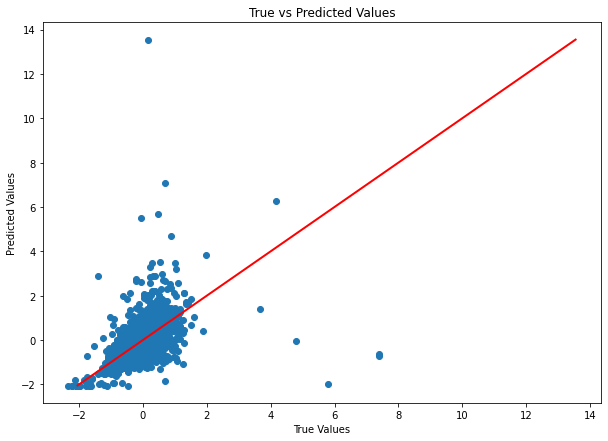

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(pred_retard2, test_df_Y_retard)
plt.plot([test_df_Y_retard.min(), test_df_Y_retard.max()], [test_df_Y_retard.min(), test_df_Y_retard.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

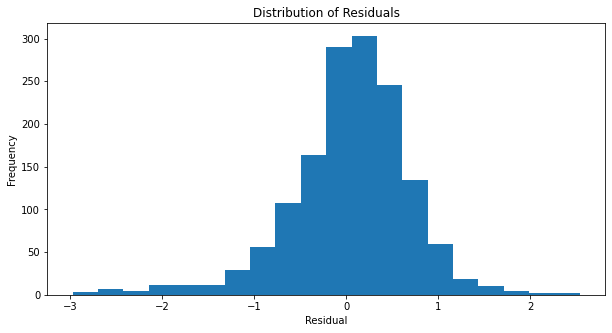

Values that are have error higher than 3: 12 of 1486


In [65]:
residuals = pred_retard2 - test_df_Y_retard
n_cut = 3
residuals_cut = residuals[abs(residuals)<n_cut]

plt.figure(figsize=(10, 5))
plt.hist(residuals_cut, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()
print(f"Values that are have error higher than {n_cut}:", sum(abs(residuals)>n_cut), "of", residuals.size)

#### GridSearch

In [89]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

# Create an instance of XGBRegressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist")

# Create the grid search object
grid_search_retard = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 0)

# Fit the grid search object to the data
grid_search_retard.fit(train_df_X.replace({True: 1, False: 0}), pd.to_numeric(train_df_Y_retard))

# Get the best combination of hyperparameters
best_params_retard = grid_search_retard.best_params_
print("Best hyperparameters:", best_params_retard)


Best hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.5}


Values that are have error higher than 3: 12 of 1486
Best hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.5}

In [92]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_params_retard)
best_xgb_model.fit(train_df_X.replace({True: 1, False: 0}), train_df_Y_retard)

# Make predictions on the test data
pred_retard3 = best_xgb_model.predict(test_df_X)

# Evaluate the model's performance
rmse3 = mean_squared_error(pred_retard3, test_df_Y_retard, squared=False)
print("Mean Squared Error:", rmse3)

r2_retatd3 = r2_score(pred_retard3, test_df_Y_retard)
print(f"R2 of the base reatard model: {r2_retatd3:.3f}")

Mean Squared Error: 0.8420283280124228
R2 of the base reatard model: -0.943


In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(colsample_bytree= 0.5, learning_rate=0.1, max_depth= 4, n_estimators= 300, subsample= 0.5)
best_xgb_model.fit(train_df_X.replace({True: 1, False: 0}), train_df_Y_retard)

# Make predictions on the test data
pred_retard3 = best_xgb_model.predict(test_df_X)

# Evaluate the model's performance
rmse3 = mean_squared_error(pred_retard3, test_df_Y_retard, squared=False)
print("Mean Squared Error:", rmse3)

r2_retatd3 = r2_score(test_df_Y_retard, pred_retard3)
print(f"R2 of the base reatard model: {r2_retatd3:.3f}")

Mean Squared Error: 0.8041548468522132
R2 of the base reatard model: 0.369


In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(colsample_bytree= 0.5, learning_rate=0.1, max_depth= 4, n_estimators= 300, subsample= 0.5)
best_xgb_model.fit(train_df_X.replace({True: 1, False: 0}), train_df_Y_retard)

# Make predictions on the test data
pred_retard3 = best_xgb_model.predict(validate_df_X)

# Evaluate the model's performance
rmse3 = mean_squared_error(pred_retard3, validate_df_Y_retard, squared=False)
print("Mean Squared Error:", rmse3)

r2_retatd3 = r2_score(validate_df_Y_retard, pred_retard3)
print(f"R2 of the base reatard model: {r2_retatd3:.3f}")

Mean Squared Error: 1.073781802071697
R2 of the base reatard model: 0.080


In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist",
                                 colsample_bytree= 0.5, learning_rate=0.1, max_depth=5 , 
                                 n_estimators= 100, subsample= 0.5)
best_xgb_model.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_retard)

# Make predictions on the test data
pred_retard3 = best_xgb_model.predict(test_df_X_dim_r)

# Evaluate the model's performance
rmse3 = mean_squared_error(pred_retard3, test_df_Y_retard, squared=False)
print("Mean Squared Error:", rmse3)

r2_retatd3 = r2_score(test_df_Y_retard, pred_retard3 )
print(f"R2 of the base reatard model: {r2_retatd3:.3f}")

Mean Squared Error: 0.8287018654050513
R2 of the base reatard model: 0.330


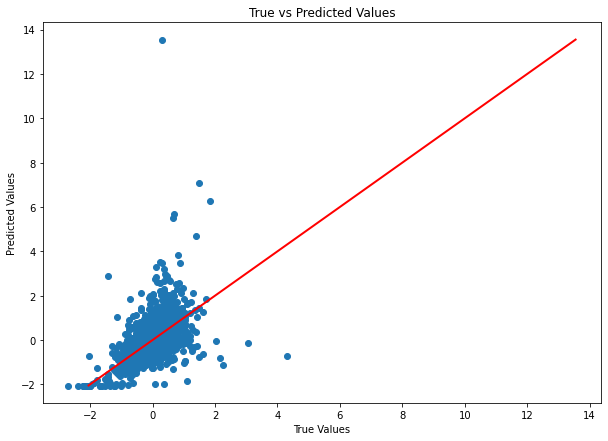

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(pred_retard3, test_df_Y_retard)
plt.plot([test_df_Y_retard.min(), test_df_Y_retard.max()], [test_df_Y_retard.min(), test_df_Y_retard.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

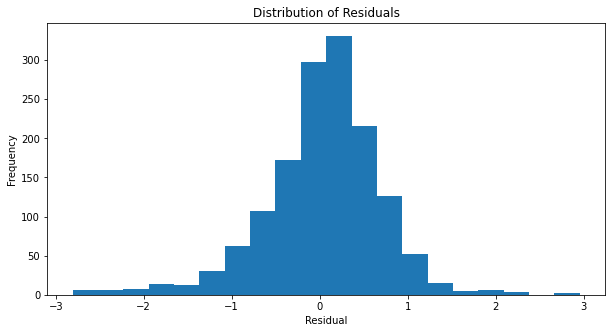

Values that are have error higher than 3: 14 of 1486


In [94]:
residuals = pred_retard3 - test_df_Y_retard
n_cut = 3
residuals_cut = residuals[abs(residuals)<n_cut]

plt.figure(figsize=(10, 5))
plt.hist(residuals_cut, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()
print(f"Values that are have error higher than {n_cut}:", sum(abs(residuals)>n_cut), "of", residuals.size)

Combine XGBoost with other models to create an ensemble for better performance.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge

# Create estimators for stacking
estimators = [
    ('xgb', xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist",
                                 colsample_bytree= 0.5, learning_rate=0.1, max_depth=5 , 
                                 n_estimators= 100, subsample= 0.5)),
    ('rf', RandomForestRegressor())
]

# Create the stacking regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=Ridge())

# Fit the stacking regressor
stacking_regressor.fit(train_df_X.replace({True: 1, False: 0}), train_df_Y_retard)

# Make predictions on the test data
pred_retard4 = best_xgb_model.predict(test_df_X)

# Evaluate the model's performance
rmse4 = mean_squared_error(pred_retard4, test_df_Y_retard, squared=False)
print("Mean Squared Error:", rmse4)

r2_retatd4 = r2_score(test_df_Y_retard, pred_retard4 )
print(f"R2 of the base reatard model: {r2_retatd4:.3f}")

### Prediction of porcentage

In [63]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

# Create a MultiOutputRegressor object
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist", 
                                                             eval_metric  = mean_absolute_error))

# Fit the model to the training data
_ = multioutputregressor.fit(train_df_X.replace({True: 1, False: 0}), train_df_Y_prct)

In [118]:
# predicting
y_pred_prct = multioutputregressor.predict(test_df_X)
print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct - test_df_Y_prct)**2, axis=0)))

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y_prct.iloc[:, i], y_pred_prct[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

Root mean square errors:
prct_cause_externe                      0.155709
prct_cause_infra                        0.155624
prct_cause_gestion_trafic               0.130990
prct_cause_materiel_roulant             0.141289
prct_cause_gestion_gare                 0.081686
prct_cause_prise_en_charge_voyageurs    0.100227
dtype: float64
Average R-squared: 0.10287310352398989


In [65]:
# validate
y_pred_prct = multioutputregressor.predict(validate_df_X)
print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct - validate_df_Y_prct)**2, axis=0)))
print("Total: ", sum(np.sqrt(np.mean((y_pred_prct - validate_df_Y_prct)**2, axis=0))))

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(validate_df_Y_prct.iloc[:, i], y_pred_prct[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

Root mean square errors:
prct_cause_externe                      0.143406
prct_cause_infra                        0.123330
prct_cause_gestion_trafic               0.132165
prct_cause_materiel_roulant             0.121584
prct_cause_gestion_gare                 0.079101
prct_cause_prise_en_charge_voyageurs    0.090292
dtype: float64
Total 0.6898774557654608
Average R-squared: 0.021551139334433256


### Grid search

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# define the grid of parameters to try
seed = 100
n_estimators = 300
learning_rate = 0.1
gamma = 0.1
subsample = 0.5
colsample_bytree = 0.5
reg_alpha = 1
reg_lambda = 1
silent = False

parameters = {}
parameters['seed'] = seed
parameters['n_estimators'] = n_estimators
parameters['learning_rate'] = learning_rate
parameters['gamma'] = gamma
parameters['colsample_bytree'] = colsample_bytree
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
parameters['silent'] = silent

scores = []

cv_params = {
    'max_depth': [5,6,7],
    'min_child_weight': [5,7,9],
    'learning_rate': [0.01, 0.1, 0.2],
    "max_leaves": [1,3,5]
}

cv_params = {
    "estimator__max_leaves": [1,3,5],
    'estimator__max_depth': [4, 5, 6],
    'estimator__learning_rate': [0.5, 0.1, 0.2],
    'estimator__min_child_weight': [5,7,9],
}
# Set no message
xgb.set_config(verbosity=0)
# create the MultiOutputRegressor model with XGBRegressor
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", 
                                                             tree_method ="gpu_hist",
                                                             eval_metric  = mean_absolute_error,
                                                             n_estimators = n_estimators,
                                                             gamma = gamma,
                                                             subsample = subsample,
                                                             colsample_bytree = colsample_bytree,
                                                             reg_alpha = reg_alpha,
                                                             reg_lambda = reg_lambda,
                                                             silent = silent))

# create the GridSearchCV object
grid_search =  GridSearchCV(multioutputregressor,
                    param_grid = cv_params,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = 0
)

# fit the model
grid_search.fit(train_df_X.replace({True: 1, False: 0}), train_df_Y_prct)

# get the best model
best_model_prct = grid_search.best_estimator_

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_absolute_error at 0x000001A6754ED9D0>,
                                            feature_types=None, gamma=0.1,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=5, min_child_weight=9,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Make predictions on the test data
y_pred_prct2 = best_model_prct.predict(test_df_X)

print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct2 - test_df_Y_prct)**2, axis=0)))

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y_prct.iloc[:, i], y_pred_prct2[:, i]))

average_r2_score2 = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score2)

Root mean square errors:
prct_cause_externe                      0.153099
prct_cause_infra                        0.150303
prct_cause_gestion_trafic               0.136140
prct_cause_materiel_roulant             0.124956
prct_cause_gestion_gare                 0.074423
prct_cause_prise_en_charge_voyageurs    0.102240
dtype: float64
Average R-squared: 0.15465488435585314


In [142]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

# Create a MultiOutputRegressor object
# multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist", 
#                                                              eval_metric  = mean_absolute_error))
best_model_prct = MultiOutputRegressor(xgb.XGBRegressor(base_score=None, booster=None,
                                                              objective="reg:squarederror",
                                                              tree_method ="gpu_hist",
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=0.5,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=mean_absolute_error,
                                                            feature_types=None, gamma=0.1,
                                                            gpu_id=None, grow_policy=None,
                                                            importance_type=None,
                                                            interaction_constraints=None,
                                                            learning_rate=0.2, max_bin=None,
                                                            max_cat_threshold=None,
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None, max_depth=4,
                                                            max_leaves=5, min_child_weight=9,
                                                            monotone_constraints=None,
                                                            n_estimators=300, n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None, random_state=None))

# Fit the model to the training data
_ = best_model_prct.fit(train_df_X.replace({True: 1, False: 0}), train_df_Y_prct)

In [143]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Make predictions on the test data
y_pred_prct2 = best_model_prct.predict(test_df_X)

print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct2 - test_df_Y_prct)**2, axis=0)))
print("Total:", sum(np.sqrt(np.mean((y_pred_prct2 - test_df_Y_prct)**2, axis=0)))/6)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y_prct.iloc[:, i], y_pred_prct2[:, i]))

average_r2_score2 = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score2)

Root mean square errors:
prct_cause_externe                      0.160036
prct_cause_infra                        0.140139
prct_cause_gestion_trafic               0.135317
prct_cause_materiel_roulant             0.131880
prct_cause_gestion_gare                 0.079236
prct_cause_prise_en_charge_voyageurs    0.097627
dtype: float64
Total: 0.12403921373696596
Average R-squared: 0.14586806568063485


In [71]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Make predictions on the validate data
y_pred_prct2 = best_model_prct.predict(validate_df_X)

print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct2 - validate_df_Y_prct)**2, axis=0)))
print("Total:",sum(np.sqrt(np.mean((y_pred_prct2 - validate_df_Y_prct)**2, axis=0))))

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(validate_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(validate_df_Y_prct.iloc[:, i], y_pred_prct2[:, i]))

average_r2_score2 = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score2)

Root mean square errors:
prct_cause_externe                      0.139028
prct_cause_infra                        0.125103
prct_cause_gestion_trafic               0.132503
prct_cause_materiel_roulant             0.123136
prct_cause_gestion_gare                 0.077197
prct_cause_prise_en_charge_voyageurs    0.079964
dtype: float64
Total: 0.6769312255039136
Average R-squared: 0.07449361153333363


### Prediction with dim_reduction

In [80]:
from dim_reduction import best_forward_feature_selection

train_df_X_dim_r = train_df_X[best_forward_feature_selection()]
test_df_X_dim_r = test_df_X[best_forward_feature_selection()]
validate_df_X_dim_r = validate_df_X[best_forward_feature_selection()]

In [81]:
import xgboost as xgb

# Create regression matrices
dtrain_reg_retard_dim_r = xgb.DMatrix(train_df_X_dim_r, train_df_Y_retard, enable_categorical=False)
dtest_reg_retard_dim_r = xgb.DMatrix(test_df_X_dim_r, test_df_Y_retard, enable_categorical=False)
dval_reg_retard_dim_r = xgb.DMatrix(validate_df_X_dim_r, validate_df_Y_retard, enable_categorical=False)

In [60]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
model_retard_dim_r = xgb.train(
   params=params,
   dtrain=dtrain_reg_retard_dim_r,
   num_boost_round=n,
)

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard_dim_r = model_retard_dim_r.predict(dtest_reg_retard_dim_r)

# Root Mean Squared Error
rmse_retard_dim_r = mean_squared_error(pred_retard_dim_r, test_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard_dim_r:.3f}")

r2_retatd_dim_r = r2_score(test_df_Y_retard, pred_retard_dim_r)
print(f"R2 of the base reatard model: {r2_retatd_dim_r:.3f}")

RMSE of the base reatard model: 0.860
R2 of the base reatard model: 0.278


In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard_dim_r = model_retard_dim_r.predict(dval_reg_retard_dim_r)

# Root Mean Squared Error
rmse_retard_dim_r = mean_squared_error(pred_retard_dim_r, validate_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard_dim_r:.3f}")

r2_retatd_dim_r = r2_score(validate_df_Y_retard, pred_retard_dim_r)
print(f"R2 of the base reatard model: {r2_retatd_dim_r:.3f}")

RMSE of the base reatard model: 1.057
R2 of the base reatard model: 0.108


#### Using Test Sets During Training

We will use evaluation arrays that allow us to see model performance as it gets improved incrementally across boosting rounds.

In [80]:
# Test and Training 
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
evals = [(dtrain_reg_retard_dim_r, "train"), (dtest_reg_retard_dim_r, "test")]

model_retard2_dim_r = xgb.train(
   params=params,
   dtrain=dtrain_reg_retard_dim_r,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10 # Every ten rounds
)

[0]	train-rmse:0.96751	test-rmse:1.01830
[10]	train-rmse:0.70816	test-rmse:0.84869
[20]	train-rmse:0.65119	test-rmse:0.84784
[30]	train-rmse:0.61788	test-rmse:0.84711
[40]	train-rmse:0.57867	test-rmse:0.83778
[50]	train-rmse:0.54084	test-rmse:0.83243
[60]	train-rmse:0.51467	test-rmse:0.83489
[70]	train-rmse:0.49076	test-rmse:0.83919
[80]	train-rmse:0.46956	test-rmse:0.83860
[90]	train-rmse:0.45189	test-rmse:0.84090
[99]	train-rmse:0.43739	test-rmse:0.84348


In [63]:
# Test and Training 
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
evals = [(dtrain_reg_retard_dim_r, "train"), (dtest_reg_retard_dim_r, "test")]

model_retard2_dim_r = xgb.train(
   params=params,
   dtrain=dtrain_reg_retard_dim_r,
   num_boost_round=n,
   evals=evals,
   verbose_eval=5, # Every ten rounds
   # Activate early stopping
   early_stopping_rounds=20
)

[0]	train-rmse:0.96807	test-rmse:1.01156


[5]	train-rmse:0.75427	test-rmse:0.86035
[10]	train-rmse:0.69512	test-rmse:0.84895
[15]	train-rmse:0.66487	test-rmse:0.84174
[20]	train-rmse:0.63824	test-rmse:0.84613
[25]	train-rmse:0.62753	test-rmse:0.84769
[30]	train-rmse:0.59140	test-rmse:0.83785
[35]	train-rmse:0.58094	test-rmse:0.84204
[40]	train-rmse:0.57077	test-rmse:0.84374
[45]	train-rmse:0.55214	test-rmse:0.84403
[47]	train-rmse:0.54478	test-rmse:0.84545


In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard2_dim_r = model_retard2_dim_r.predict(dtest_reg_retard_dim_r)

# Root Mean Squared Error
rmse_retard2_dim_r = mean_squared_error(pred_retard2_dim_r, test_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard2_dim_r:.3f}")

r2_retatd2_dim_r = r2_score(test_df_Y_retard, pred_retard2_dim_r)
print(f"R2 of the base reatard model: {r2_retatd2_dim_r:.3f}")

RMSE of the base reatard model: 0.845
R2 of the base reatard model: 0.303


In [65]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred_retard2_dim_r = model_retard2_dim_r.predict(dval_reg_retard_dim_r)

# Root Mean Squared Error
rmse_retard2_dim_r = mean_squared_error(pred_retard2_dim_r, validate_df_Y_retard, squared=False) # True: MSE False:RMSE
print(f"RMSE of the base reatard model: {rmse_retard2_dim_r:.3f}")

r2_retatd2_dim_r = r2_score(validate_df_Y_retard, pred_retard2_dim_r)
print(f"R2 of the base reatard model: {r2_retatd2_dim_r:.3f}")

RMSE of the base reatard model: 1.046
R2 of the base reatard model: 0.127


#### Plot results

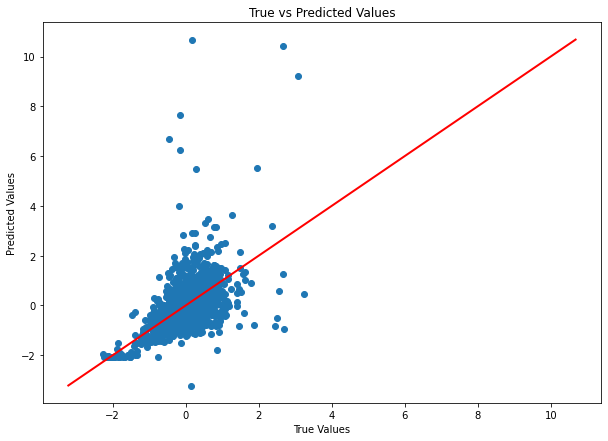

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(pred_retard2_dim_r, test_df_Y_retard)
plt.plot([test_df_Y_retard.min(), test_df_Y_retard.max()], [test_df_Y_retard.min(), test_df_Y_retard.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

#### Grid search from before

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Best parameters
parameters = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.5}

# Train the model with the best hyperparameters
best_xgb_model_dim_r = xgb.XGBRegressor(colsample_bytree= 0.5, learning_rate=0.1, max_depth= 4, n_estimators =300, subsample= 0.5, objective="reg:squarederror", tree_method ="gpu_hist")
best_xgb_model_dim_r.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_retard)

# Make predictions on the test data
pred_retard3_dim_r = best_xgb_model_dim_r.predict(test_df_X_dim_r)

# Evaluate the model's performance
rmse3_dim_r = mean_squared_error(pred_retard3_dim_r, test_df_Y_retard, squared=False)
print("Mean Squared Error:", rmse3_dim_r)

r2_retatd3_dim_r = r2_score(test_df_Y_retard, pred_retard3_dim_r)
print(f"R2 of the base reatard model: {r2_retatd3_dim_r:.3f}")

Mean Squared Error: 0.8425075203677308
R2 of the base reatard model: 0.308


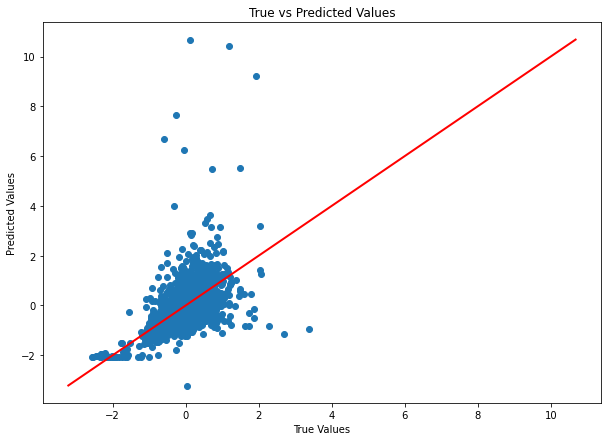

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(pred_retard3_dim_r, test_df_Y_retard)
plt.plot([test_df_Y_retard.min(), test_df_Y_retard.max()], [test_df_Y_retard.min(), test_df_Y_retard.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

#### GridSerach new

In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

# Create an instance of XGBRegressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist")

# Create the grid search object
grid_search_retard = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 0)

# Fit the grid search object to the data
grid_search_retard.fit(train_df_X_dim_r.replace({True: 1, False: 0}), pd.to_numeric(train_df_Y_retard))

# Get the best combination of hyperparameters
best_params_retard_dim_r = grid_search_retard.best_params_



In [42]:
print("Best hyperparameters:", best_params_retard_dim_r)

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train the model with the best hyperparameters
best_xgb_model_dim_r = xgb.XGBRegressor(colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 5, n_estimators= 100, subsample=0.8)
best_xgb_model_dim_r.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_retard)

# Make predictions on the test data
pred_retard3_dim_r = best_xgb_model_dim_r.predict(test_df_X_dim_r)

# Evaluate the model's performance
rmse3_dim_r = mean_squared_error(pred_retard3_dim_r, test_df_Y_retard, squared=False)
print("Mean Squared Error:", rmse3_dim_r)

r2_retatd3_dim_r = r2_score(test_df_Y_retard, pred_retard3_dim_r)
print(f"R2 of the base reatard model: {r2_retatd3_dim_r:.3f}")

Mean Squared Error: 0.8164141396870257
R2 of the base reatard model: 0.350


In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train the model with the best hyperparameters
best_xgb_model_dim_r = xgb.XGBRegressor(colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 5, n_estimators= 100, subsample=0.8)
best_xgb_model_dim_r.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_retard)

# Make predictions on the test data
pred_retard3_dim_r = best_xgb_model_dim_r.predict(validate_df_X_dim_r)

# Evaluate the model's performance
rmse3_dim_r = mean_squared_error(pred_retard3_dim_r, validate_df_Y_retard, squared=False)
print("Mean Squared Error:", rmse3_dim_r)

r2_retatd3_dim_r = r2_score(validate_df_Y_retard, pred_retard3_dim_r)
print(f"R2 of the base reatard model: {r2_retatd3_dim_r:.3f}")

Mean Squared Error: 1.0288901527314849
R2 of the base reatard model: 0.156


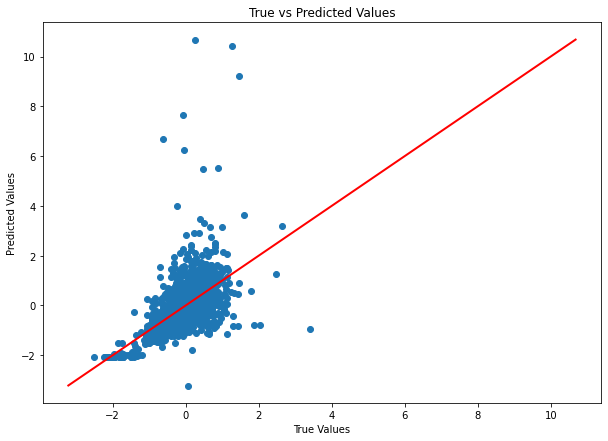

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(pred_retard3_dim_r, test_df_Y_retard)
plt.plot([test_df_Y_retard.min(), test_df_Y_retard.max()], [test_df_Y_retard.min(), test_df_Y_retard.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

### Prediciton of porcentage with dim_reduction

In [87]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

# Create a MultiOutputRegressor object
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist", 
                                                             eval_metric  = mean_absolute_error))

# Fit the model to the training data
_ = multioutputregressor.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_prct)

In [88]:
y_pred_prct_dim_r = multioutputregressor.predict(test_df_X_dim_r)
print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct_dim_r - test_df_Y_prct)**2, axis=0)))

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y_prct.iloc[:, i], y_pred_prct_dim_r[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

Root mean square errors:
prct_cause_externe                      0.164194
prct_cause_infra                        0.139848
prct_cause_gestion_trafic               0.135104
prct_cause_materiel_roulant             0.140278
prct_cause_gestion_gare                 0.083938
prct_cause_prise_en_charge_voyageurs    0.100326
dtype: float64
Average R-squared: 0.09395796154675529


In [92]:
y_pred_prct_dim_r = multioutputregressor.predict(validate_df_X_dim_r)
print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct_dim_r - validate_df_Y_prct)**2, axis=0)))
print("Total:", sum(np.sqrt(np.mean((y_pred_prct_dim_r - validate_df_Y_prct)**2, axis=0)))/6)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(validate_df_Y_prct.iloc[:, i], y_pred_prct_dim_r[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

Root mean square errors:
prct_cause_externe                      0.133159
prct_cause_infra                        0.125242
prct_cause_gestion_trafic               0.125742
prct_cause_materiel_roulant             0.123811
prct_cause_gestion_gare                 0.077195
prct_cause_prise_en_charge_voyageurs    0.087634
dtype: float64
Total: 0.11213069204554955
Average R-squared: 0.06769675334865942


#### Grid Search ussed values

In [39]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

# Create a MultiOutputRegressor object
# multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist", 
#                                                              eval_metric  = mean_absolute_error))
best_model_prct = MultiOutputRegressor(xgb.XGBRegressor(base_score=None, booster=None,
                                                              objective="reg:squarederror",
                                                              tree_method ="gpu_hist",
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=0.5,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=mean_absolute_error,
                                                            feature_types=None, gamma=0.1,
                                                            gpu_id=None, grow_policy=None,
                                                            importance_type=None,
                                                            interaction_constraints=None,
                                                            learning_rate=0.2, max_bin=None,
                                                            max_cat_threshold=None,
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None, max_depth=4,
                                                            max_leaves=5, min_child_weight=9,
                                                            monotone_constraints=None,
                                                            n_estimators=300, n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None, random_state=None))

# Fit the model to the training data
_ = best_model_prct.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_prct)

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Make predictions on the test data
y_pred_prct2_dim_r = best_model_prct.predict(test_df_X_dim_r)

print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct2_dim_r - test_df_Y_prct)**2, axis=0)))

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y_prct.iloc[:, i], y_pred_prct2_dim_r[:, i]))

average_r2_score2 = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score2)

Root mean square errors:
prct_cause_externe                      0.156231
prct_cause_infra                        0.144466
prct_cause_gestion_trafic               0.134904
prct_cause_materiel_roulant             0.125189
prct_cause_gestion_gare                 0.082308
prct_cause_prise_en_charge_voyageurs    0.098418
dtype: float64
Average R-squared: 0.13993641910813595


#### Pred with gridsearch

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# define the grid of parameters to try
seed = 100
n_estimators = 300
learning_rate = 0.1
gamma = 0.1
subsample = 0.5
colsample_bytree = 0.5
reg_alpha = 1
reg_lambda = 1
silent = False

parameters = {}
parameters['seed'] = seed
parameters['n_estimators'] = n_estimators
parameters['learning_rate'] = learning_rate
parameters['gamma'] = gamma
parameters['colsample_bytree'] = colsample_bytree
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
parameters['silent'] = silent

scores = []

cv_params = {
    'max_depth': [5,6,7],
    'min_child_weight': [5,7,9],
    'learning_rate': [0.01, 0.1, 0.2],
    "max_leaves": [1,3,5]
}

cv_params = {
    "estimator__max_leaves": [1,3,5],
    'estimator__max_depth': [4, 5, 6],
    'estimator__learning_rate': [0.5, 0.1, 0.2],
    'estimator__min_child_weight': [5,7,9],
}
# Set no message
xgb.set_config(verbosity=0)
# create the MultiOutputRegressor model with XGBRegressor
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", 
                                                             tree_method ="gpu_hist",
                                                             eval_metric  = mean_absolute_error,
                                                             n_estimators = n_estimators,
                                                             gamma = gamma,
                                                             subsample = subsample,
                                                             colsample_bytree = colsample_bytree,
                                                             reg_alpha = reg_alpha,
                                                             reg_lambda = reg_lambda,
                                                             silent = silent))

# create the GridSearchCV object
grid_search =  GridSearchCV(multioutputregressor,
                    param_grid = cv_params,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = 0
)

# fit the model
grid_search.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_prct)

# get the best model
best_model_prct_dim_r = grid_search.best_estimator_

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_absolute_error at 0x000002602BD0A430>,
                                            feature_types=None, gamma=0.1,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=5, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [100]:
from sklearn.metrics import mean_absolute_error
best_model_prct_dim_r = MultiOutputRegressor(xgb.XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=mean_absolute_error,
                                            feature_types=None, gamma=0.1,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=5, min_child_weight=7,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None))
_ = best_model_prct_dim_r.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_prct)

In [144]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Make predictions on the test data
y_pred_prct2_dim_r = best_model_prct_dim_r.predict(test_df_X_dim_r)

print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct2_dim_r - test_df_Y_prct)**2, axis=0)))
print("Total:", sum(np.sqrt(np.mean((y_pred_prct2_dim_r - test_df_Y_prct)**2, axis=0)))/6)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y_prct.iloc[:, i], y_pred_prct2_dim_r[:, i]))

average_r2_score2 = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score2)

Root mean square errors:
prct_cause_externe                      0.159792
prct_cause_infra                        0.138639
prct_cause_gestion_trafic               0.134100
prct_cause_materiel_roulant             0.131540
prct_cause_gestion_gare                 0.079535
prct_cause_prise_en_charge_voyageurs    0.096403
dtype: float64
Total: 0.12333489254244588
Average R-squared: 0.1548207924959194


In [103]:
# Validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Make predictions on the test data
y_pred_prct2_dim_r = best_model_prct_dim_r.predict(validate_df_X_dim_r)

print("Root mean square errors:")
print(np.sqrt(np.mean((y_pred_prct2_dim_r - validate_df_Y_prct)**2, axis=0)))
print("Total:", sum(np.sqrt(np.mean((y_pred_prct2_dim_r - validate_df_Y_prct)**2, axis=0)))/6)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(validate_df_Y_prct.shape[1]):
    output_r2_scores.append(r2_score(validate_df_Y_prct.iloc[:, i], y_pred_prct2_dim_r[:, i]))

average_r2_score2 = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score2)


Root mean square errors:
prct_cause_externe                      0.133827
prct_cause_infra                        0.119292
prct_cause_gestion_trafic               0.125377
prct_cause_materiel_roulant             0.119971
prct_cause_gestion_gare                 0.075669
prct_cause_prise_en_charge_voyageurs    0.078107
dtype: float64
Total: 0.10870720380859995
Average R-squared: 0.13601099224279614


#### Predict both

In [113]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor

# Test and Training 
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

# Create a MultiOutputRegressor object
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))

# Fit the model to the training data
_ = multioutputregressor.fit(train_df_X, train_df_Y)

In [110]:
# predicting
y_pred = multioutputregressor.predict(test_df_X)
print(np.mean((y_pred - test_df_Y)**2, axis=0))  # 0.004, 0.003, 0.005
print("Total:", sum(np.mean((y_pred - test_df_Y)**2, axis=0))/7)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y.iloc[:, i], y_pred[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

prct_cause_externe                      0.024430
prct_cause_infra                        0.019136
prct_cause_gestion_trafic               0.018653
prct_cause_materiel_roulant             0.018818
prct_cause_gestion_gare                 0.006908
prct_cause_prise_en_charge_voyageurs    0.009344
total_retard_mean                       0.677356
dtype: float64
Total: 0.11066364609392418
Average R-squared: 0.16251385962912884


In [114]:
# predicting
y_pred = multioutputregressor.predict(validate_df_X)
print(np.mean((y_pred - validate_df_Y)**2, axis=0))  # 0.004, 0.003, 0.005
print("Total:", sum(np.mean((y_pred - validate_df_Y)**2, axis=0))/7)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y.shape[1]):
    output_r2_scores.append(r2_score(validate_df_Y.iloc[:, i], y_pred[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

prct_cause_externe                      0.022984
prct_cause_infra                        0.015615
prct_cause_gestion_trafic               0.017628
prct_cause_materiel_roulant             0.014490
prct_cause_gestion_gare                 0.006013
prct_cause_prise_en_charge_voyageurs    0.007332
total_retard_mean                       1.184476
dtype: float64
Total: 0.18121994730319987
Average R-squared: 0.028975156626309957


#### Grid Search

In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

# define the grid of parameters to try
objective = "reg:linear"
seed = 100
n_estimators = 100
learning_rate = 0.1
gamma = 0.1
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 1
reg_lambda = 1
silent = False

parameters = {}
parameters['objective'] = objective
parameters['seed'] = seed
parameters['n_estimators'] = n_estimators
parameters['learning_rate'] = learning_rate
parameters['gamma'] = gamma
parameters['colsample_bytree'] = colsample_bytree
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
parameters['silent'] = silent

scores = []

cv_params = {
    'max_depth': [5,6,7],
    'min_child_weight': [5,7,9],
    "max_leaves": [1,3,5]
}
# Set no message
xgb.set_config(verbosity=0)
# create the MultiOutputRegressor model with XGBRegressor
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))

# create the GridSearchCV object
grid_search =  GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent
                                    ),
                    
                    param_grid = cv_params,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = 0
)

# fit the model
grid_search.fit(train_df_X, train_df_Y)


# get the best model
best_model = grid_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=1, min_child_weight=5,
             missing=nan, monotone_constraints=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, objective='reg:linear',
             predictor=None, ...)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=1, min_child_weight=5,
             missing=nan, monotone_constraints=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, objective='reg:linear',
             predictor=None, ...)

In [121]:
# predicting
y_pred = best_model.predict(test_df_X)
print(np.mean((y_pred - test_df_Y)**2, axis=0))  # 0.004, 0.003, 0.005
print("Total:", sum(np.mean((y_pred - test_df_Y)**2, axis=0))/7)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y.iloc[:, i], y_pred[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

prct_cause_externe                      0.024672
prct_cause_infra                        0.018405
prct_cause_gestion_trafic               0.017564
prct_cause_materiel_roulant             0.017023
prct_cause_gestion_gare                 0.006271
prct_cause_prise_en_charge_voyageurs    0.009178
total_retard_mean                       0.641485
dtype: float64
Total: 0.1049425329239091
Average R-squared: 0.20523907081988818


### Predict both dim reduction

In [7]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Test and Training 
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

# Create a MultiOutputRegressor object
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))

# Fit the model to the training data
_ = multioutputregressor.fit(train_df_X_dim_r, train_df_Y)

In [116]:
# predicting
y_pred = multioutputregressor.predict(test_df_X_dim_r)
print(np.mean((y_pred - test_df_Y)**2, axis=0))  # 0.004, 0.003, 0.005
print("Total:", sum(np.mean((y_pred - test_df_Y)**2, axis=0))/7)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y.shape[1]):
    output_r2_scores.append(r2_score(test_df_Y.iloc[:, i], y_pred[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

prct_cause_externe                      0.026398
prct_cause_infra                        0.019930
prct_cause_gestion_trafic               0.018822
prct_cause_materiel_roulant             0.018744
prct_cause_gestion_gare                 0.007041
prct_cause_prise_en_charge_voyageurs    0.009705
total_retard_mean                       0.734763
dtype: float64
Total: 0.1193434058107113
Average R-squared: 0.13241553444962165


#### Evolution of algorithm in graphs

In [82]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

n_estimators = [50, 100, 300,500, 1000]

r2_scores_retard_n_estimators = []
rmse_scores_retard_n_estimators = []
r2_scores_retard_n_estimators_val = []
rmse_scores_retard_n_estimators_val = []

for estimator in n_estimators: 
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist",
                                 colsample_bytree= 0.5, learning_rate=0.1, max_depth= 4, 
                                 n_estimators= estimator, subsample= 0.5)
    # Fit model
    xgb_model.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_retard)
    # Predict test
    pred_y = xgb_model.predict(test_df_X_dim_r)
    
    # Calcualte scores
    r2 = r2_score(test_df_Y_retard, pred_y)
    rmse = mean_squared_error(test_df_Y_retard, pred_y, squared=False)

    r2_scores_retard_n_estimators.append(r2)
    rmse_scores_retard_n_estimators.append(rmse)

    # Predict validation
    pred_y = xgb_model.predict(validate_df_X_dim_r)
    
    # Calcualte scores
    r2 = r2_score(validate_df_Y_retard, pred_y)
    rmse = mean_squared_error(validate_df_Y_retard, pred_y, squared=False)

    r2_scores_retard_n_estimators_val.append(r2)
    rmse_scores_retard_n_estimators_val.append(rmse)

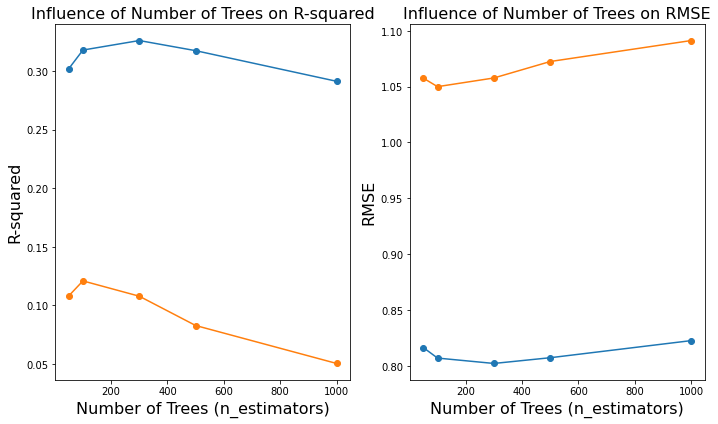

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
font_size = 16

# r2 plot
plt.subplot(1, 2, 1)
plt.plot(n_estimators, r2_scores_retard_n_estimators, marker='o')
plt.plot(n_estimators, r2_scores_retard_n_estimators_val, marker='o')
plt.xlabel('Number of Trees (n_estimators)', fontsize=font_size)
plt.ylabel('R-squared', fontsize=font_size)
plt.title('Influence of Number of Trees on R-squared', fontsize=font_size)


# mse plot
plt.subplot(1, 2, 2)
plt.plot(n_estimators, rmse_scores_retard_n_estimators, marker='o')
plt.plot(n_estimators, rmse_scores_retard_n_estimators_val, marker='o')
plt.xlabel('Number of Trees (n_estimators)', fontsize=font_size)
plt.ylabel('RMSE', fontsize=font_size)
plt.title('Influence of Number of Trees on RMSE', fontsize=font_size)

plt.tight_layout()
plt.show()

In [84]:
max_depth = [1 ,2,3,4,5,6]

r2_scores_retard_max_depth = []
rmse_scores_retard_max_depth = []
r2_scores_retard_max_depth_val = []
rmse_scores_retard_max_depth_val = []

for depth in max_depth: 
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist",
                                 colsample_bytree= 0.5, learning_rate=0.1, max_depth=depth , 
                                 n_estimators= 300, subsample= 0.5)
    # Fit model
    xgb_model.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_retard)
    # Predict
    pred_y = xgb_model.predict(test_df_X_dim_r)
    
    # Calcualte scores
    r2 = r2_score(test_df_Y_retard, pred_y)
    rmse = mean_squared_error(test_df_Y_retard, pred_y, squared=False)

    r2_scores_retard_max_depth.append(r2)
    rmse_scores_retard_max_depth.append(rmse)

    # Predict
    pred_y = xgb_model.predict(validate_df_X_dim_r)
    
    # Calcualte scores
    r2 = r2_score(validate_df_Y_retard, pred_y)
    rmse = mean_squared_error(validate_df_Y_retard, pred_y, squared=False)

    r2_scores_retard_max_depth_val.append(r2)
    rmse_scores_retard_max_depth_val.append(rmse)

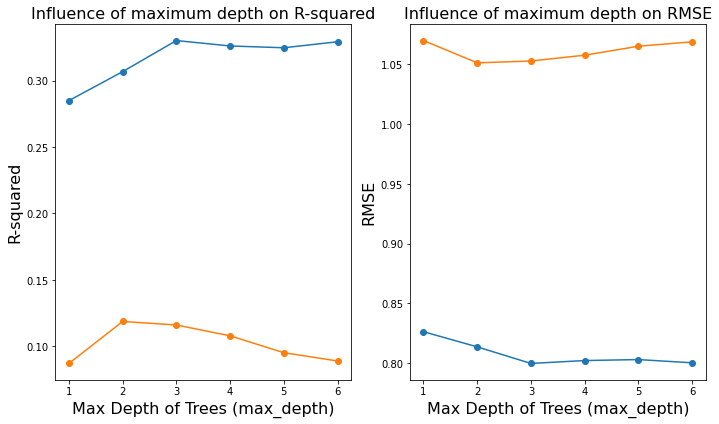

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
# Set the font size for labels and titles
font_size = 16

# r2 plot
plt.subplot(1, 2, 1)
plt.plot(max_depth, r2_scores_retard_max_depth, marker='o')
plt.plot(max_depth, r2_scores_retard_max_depth_val, marker='o')
plt.xlabel('Max Depth of Trees (max_depth)', fontsize=font_size)
plt.ylabel('R-squared', fontsize=font_size)
plt.title('Influence of maximum depth on R-squared', fontsize=font_size)


# mse plot
plt.subplot(1, 2, 2)
plt.plot(max_depth, rmse_scores_retard_max_depth, marker='o')
plt.plot(max_depth, rmse_scores_retard_max_depth_val, marker='o')
plt.xlabel('Max Depth of Trees (max_depth)', fontsize=font_size)
plt.ylabel('RMSE', fontsize=font_size)
plt.title('Influence of maximum depth on RMSE', fontsize=font_size)

plt.tight_layout()
plt.show()

In [88]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method ="gpu_hist",
                                 colsample_bytree= 0.5, learning_rate=0.1, max_depth=3 , 
                                 n_estimators= 300, subsample= 0.5)
# Fit model
xgb_model.fit(train_df_X_dim_r.replace({True: 1, False: 0}), train_df_Y_retard)

# Predict
pred_y = xgb_model.predict(test_df_X_dim_r)

# Calcualte scores
r2 = r2_score(test_df_Y_retard, pred_y)
rmse = mean_squared_error(test_df_Y_retard, pred_y, squared=False)

print("RMSE:", r2)
print("R-squared:", rmse)

RMSE: 0.33015705600448175
R-squared: 0.7997464052997648


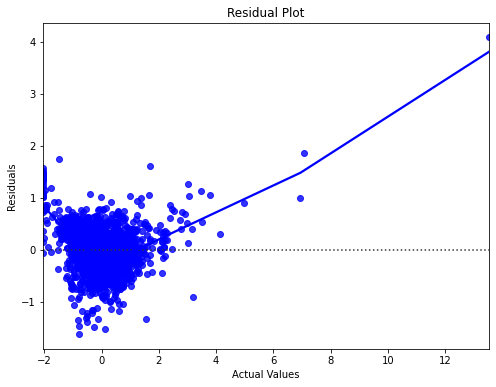

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = test_df_Y_retard - pred_y
plt.figure(figsize=(8, 6))
sns.residplot(x=test_df_Y_retard, y=residuals, lowess=True, color="b")
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
# predicting
y_pred = multioutputregressor.predict(validate_df_X_dim_r)
print(np.mean((y_pred - validate_df_Y)**2, axis=0))  # 0.004, 0.003, 0.005
print("Total:", sum(np.mean((y_pred - validate_df_Y)**2, axis=0))/7)

# Calculate the R-squared for the MultiOutputRegressor
output_r2_scores = []
for i in range(test_df_Y.shape[1]):
    output_r2_scores.append(r2_score(validate_df_Y.iloc[:, i], y_pred[:, i]))

average_r2_score = np.mean(output_r2_scores)
# Print the R-squared
print("Average R-squared:", average_r2_score)

In [ ]:
def calculate_r2(x,y):
    # calculare the r2 between the list x and y
    